Hi. This is homework 3, the intermediate data science project.

The link to the intermediate tutorial is [here](https://www.tensorflow.org/text/tutorials/text_classification_rnn).

In [ ]:
# Setup

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

def plot_graphs(history, metric): # helper function to plot graphs of trained models
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '') # the empty string supresses warning due to ambiguity
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
# Setup input pipeline

dataset, info = tfds.load('imdb_reviews', with_info = True, as_supervised = True)

train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete412A65/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete412A65/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete412A65/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print(info)
print(dataset)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [ ]:
train_dataset.element_spec

for i in range(5):
  for example, label in train_dataset.take(i): # prints some of our data and their classification. 0 is a bad review | 1 is a good review
    print(f"Text: {example}")
    print(f"Label: {label}")

Text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0
Text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie i

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # after looking a tf docs, buffer size is essentially how many elemetnts are taken at a time to become randomly shuffled and replaced from thesame group of taken elements
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # the buffer size value passed into prefetch is autotuned by a tf algorithm

In [ ]:
for example, label in train_dataset.take(1): # the 1 represents 1 batch . before one batch meant 1 example, however, above we have changed the batch size to 64 thus we get 64 examples everytime we .take(1) from the train dataset
  print('texts: ', example.numpy())
  print()
  print('labels: ', label.numpy())

texts:  [b"I totally agree with the review by a reviewer of Variety that the film is never quite as funny, lively or insightful about the creative process as its premise would seem to warrant. Narratively it is messy and the lighting is really problematic. If the film is supposed to be character-driven the poor lighting doesn't enhance the acting and it is sometimes difficult to observe the facial expressions of the actors. Many non-South Africans will have difficulty in following the spoken English in the film and some of the local humor will be lost in the process. I watched the film at the Cape Town World Cinema festival last year. Comments and reactions to the film ranged from unwatchable and sloppy to a welcome departure from the films about our painful past. Unfortunately Bunny Chow won't be remembered as one of the bright lights of the South African New Wave, but some of the remarkable films about our apartheid history will indeed be rated among our best in our 110 year old film

In [ ]:
# Creating the text encoder

vocab_size = 1000
# the textvectorization removes punctuation and lower cases the text, creates vocabulary (when passed into it or when the .apply method is used onto it with the data) and changes the words in each example to the index of the word in the vocab
encoder = tf.keras.layers.TextVectorization(vocab_size) # if data contains more unique words than vocab_size then only the most frequent words will be added to the vocaburaly
encoder.adapt(train_dataset.map(lambda text, label: text)) # the '.map(lambda text, label: text)' gets only the feature data from the train_dataset (filtering out the labels) so that the adapt can create the vocabulary of the dataset

vocab = np.array(encoder.get_vocabulary())
print(len(vocab))
print(vocab[0:20])

print(len(example))
encoded_example = encoder(example)[:3].numpy() # for this to work we must have previously either passed in a vocabulary intot he textvectorization encoder or did the .adapt method onto the data to get the enocder to create a vocab for the data
print(encoded_example) # this is the data where text is encoded into indicies of words in the vocabulary. each row is one text example with 0(s) padded at the end if it is shorter than other text examples
print(len(encoded_example[0]))

print(vocab[2])
print(example.numpy()[0]) # we can see that the first word for the first example is 'the' and that it has index 2 in the vocab

1000
['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'for' 'with' 'movie' 'but']
64
[[ 10 467   1 ...   0   0   0]
 [ 11   7   4 ...   0   0   0]
 [ 10 434  11 ...   0   0   0]]
953
the
b"I totally agree with the review by a reviewer of Variety that the film is never quite as funny, lively or insightful about the creative process as its premise would seem to warrant. Narratively it is messy and the lighting is really problematic. If the film is supposed to be character-driven the poor lighting doesn't enhance the acting and it is sometimes difficult to observe the facial expressions of the actors. Many non-South Africans will have difficulty in following the spoken English in the film and some of the local humor will be lost in the process. I watched the film at the Cape Town World Cinema festival last year. Comments and reactions to the film ranged from unwatchable and sloppy to a welcome departure from the films about our painful past. Unfortun

In [ ]:
for n in range(3): # this shows that we can not get back the example from the vocab because not all words used inthe examples are in the vocab because we have mor eunique words in all the examples than the max number of vocab which we defined the enocder with
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I totally agree with the review by a reviewer of Variety that the film is never quite as funny, lively or insightful about the creative process as its premise would seem to warrant. Narratively it is messy and the lighting is really problematic. If the film is supposed to be character-driven the poor lighting doesn't enhance the acting and it is sometimes difficult to observe the facial expressions of the actors. Many non-South Africans will have difficulty in following the spoken English in the film and some of the local humor will be lost in the process. I watched the film at the Cape Town World Cinema festival last year. Comments and reactions to the film ranged from unwatchable and sloppy to a welcome departure from the films about our painful past. Unfortunately Bunny Chow won't be remembered as one of the bright lights of the South African New Wave, but some of the remarkable films about our apartheid history will indeed be rated among our best in our 110 year old fi

In [ ]:
# Create the model

model = tf.keras.Sequential([
                             encoder, 
                             tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),# changes the indicies of the words into vectors representing each word, after training the vectors will have changed and similar meaning words will have similar vectors | mask_zero = True masks out / ignores/skips 0/repeated values which we need since we added zero values as padding to our encoded data
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # 2 layers which feed-forward and then feed-backword and then repeat to each other | after searching, LSTM is a rnn layer type which has been introduced to find long-term dependecies/meanings in inputed text sequences/sentences
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1) # output layer (does the classification)
                             ])

In [ ]:
print([layer.supports_masking for layer in model.layers]) # because masking has been turned on in the second layer

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
prediction = model.predict(np.array([sample_text]))
print(prediction)

padding = 'hi' * 2000

prediction2 = model.predict(np.array([sample_text, padding]))
print(prediction2)

[[0.00618953]]
[[0.00618953]
 [0.00443069]]


In [ ]:
# now we will Compile the Keras model to configure the training process

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # from_logits = False means that y_pred contains probabilities / values between 0 and 1, but this is not the case as our output will be either 0 (negative review) or 1 (positive review)
              optimizer = tf.keras.optimizers.Adam(1e-4), # the 1e-4 is the epsilon used for 'numerical stability' as said in tf docs
              metrics = ['accuracy'])



In [ ]:
# Train the model

history = model.fit(train_dataset, epochs = 10, validation_data = test_dataset, validation_steps = 30)



Epoch 1/10
391/391 [==============================] - 43s 88ms/step - loss: 0.6542 - accuracy: 0.5588 - val_loss: 0.5682 - val_accuracy: 0.6724
Epoch 2/10
391/391 [==============================] - 32s 80ms/step - loss: 0.4656 - accuracy: 0.7690 - val_loss: 0.4103 - val_accuracy: 0.8089
Epoch 3/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3994 - accuracy: 0.8274 - val_loss: 0.3802 - val_accuracy: 0.8292
Epoch 4/10
391/391 [==============================] - 32s 80ms/step - loss: 0.3496 - accuracy: 0.8468 - val_loss: 0.3491 - val_accuracy: 0.8391
Epoch 5/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3277 - accuracy: 0.8588 - val_loss: 0.3389 - val_accuracy: 0.8526
Epoch 6/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3165 - accuracy: 0.8652 - val_loss: 0.3292 - val_accuracy: 0.8484
Epoch 7/10
391/391 [==============================] - 33s 82ms/step - loss: 0.3095 - accuracy: 0.8686 - val_loss: 0.3369 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

391/391 [==============================] - 19s 49ms/step - loss: 0.3163 - accuracy: 0.8592
Test loss: 0.3163262605667114
Test accuracy: 0.8592000007629395


(0.0, 0.6720378592610359)

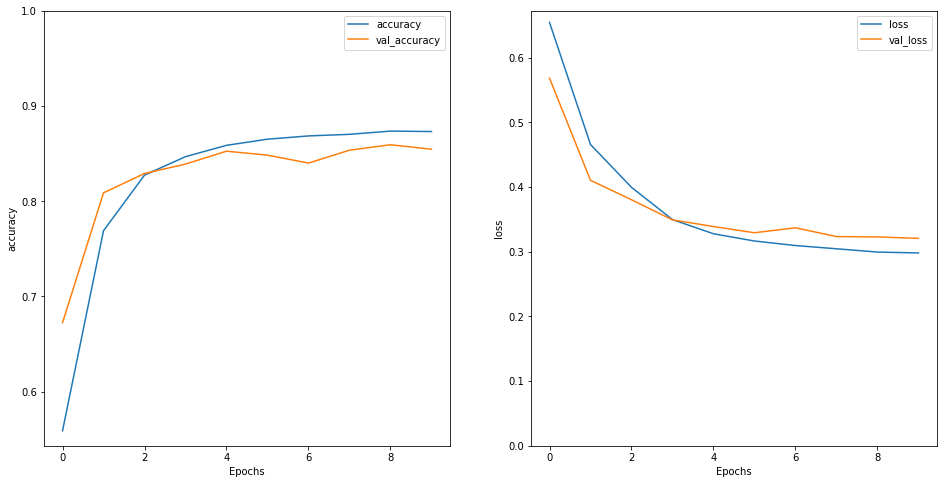

In [ ]:
plt.figure(figsize = (16,8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
prediction = model.predict(np.array([sample_text]))

# "If the prediction is >= 0.0, it is positive else it is negative."

if prediction[0] >= 0:
  print("Positive review")
else:
  print("Negative review")

Positive review


In [ ]:
print(history.history) # history is a dictionary storing the accuracy and losses for the training and validation datasets

{'loss': [0.6542284488677979, 0.4656013250350952, 0.39943793416023254, 0.34955140948295593, 0.3276606500148773, 0.3164554536342621, 0.30946993827819824, 0.304472416639328, 0.29938480257987976, 0.2980402410030365], 'accuracy': [0.5587599873542786, 0.7689999938011169, 0.8274400234222412, 0.8468400239944458, 0.8587599992752075, 0.8651999831199646, 0.8686400055885315, 0.8703200221061707, 0.8737199902534485, 0.8732399940490723], 'val_loss': [0.5681758522987366, 0.41032829880714417, 0.38020429015159607, 0.34913283586502075, 0.3388543725013733, 0.3292410671710968, 0.33686521649360657, 0.32334616780281067, 0.3227793276309967, 0.32055166363716125], 'val_accuracy': [0.6723958253860474, 0.8088541626930237, 0.8291666507720947, 0.839062511920929, 0.8526041507720947, 0.848437488079071, 0.8401041626930237, 0.8536458611488342, 0.859375, 0.854687511920929]}


Epoch 1/10
391/391 [==============================] - 74s 154ms/step - loss: 0.6359 - accuracy: 0.5784 - val_loss: 0.4467 - val_accuracy: 0.7797
Epoch 2/10
391/391 [==============================] - 56s 143ms/step - loss: 0.3954 - accuracy: 0.8237 - val_loss: 0.3706 - val_accuracy: 0.8422
Epoch 3/10
391/391 [==============================] - 56s 141ms/step - loss: 0.3457 - accuracy: 0.8506 - val_loss: 0.3357 - val_accuracy: 0.8589
Epoch 4/10
391/391 [==============================] - 58s 146ms/step - loss: 0.3215 - accuracy: 0.8650 - val_loss: 0.3341 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 58s 146ms/step - loss: 0.3123 - accuracy: 0.8651 - val_loss: 0.3191 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 57s 143ms/step - loss: 0.3073 - accuracy: 0.8683 - val_loss: 0.3229 - val_accuracy: 0.8510
Epoch 7/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3063 - accuracy: 0.8687 - val_loss: 0.3536 - val_ac

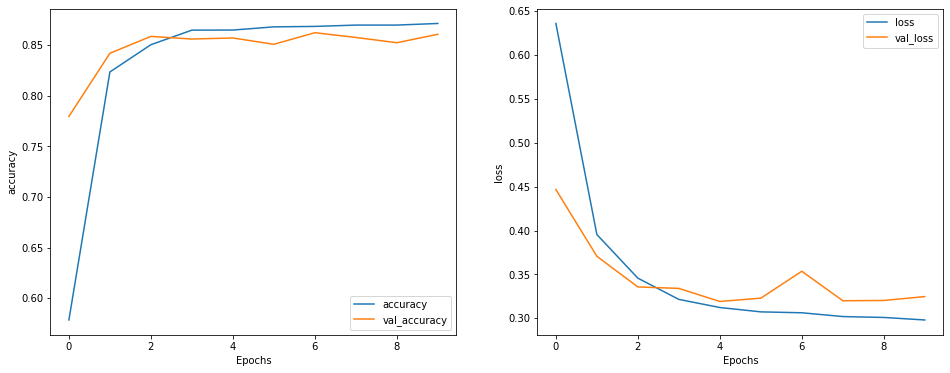

In [ ]:
# Stack two or more LSTM layers

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)), # return_sequence = True return a 3d output which allows the output to be passed into a second LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5), # helps reduce overfitting
    tf.keras.layers.Dense(1)
])

# repeating what we did for the previous model

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')